## Temperature Inversion Analysis
Exploratory analysis of temperature inversions seen between `TREFHT` and the lowest model levels in CESM.

In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import sys


sys.path.append('/home/users/jamd1/Isca/')
from isca_tools import cesm
from isca_tools.era5.get_jasmin_era5 import Find_era5
from isca_tools.utils import area_weighting, lat_lon_rolling, print_ds_var_list, set_attrs
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.utils.moist_physics import moist_static_energy, sphum_sat
from isca_tools.utils.constants import g, c_p, lapse_dry
from isca_tools.convection.base import lcl_metpy
import isca_tools
import cftime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
import matplotlib.patches as patches
from tqdm.notebook import tqdm
import matplotlib
from matplotlib.dates import ConciseDateConverter
matplotlib.units.registry[cftime.DatetimeNoLeap] = ConciseDateConverter()  # to allow plotting time as x axis
plt.style.use('/home/users/jamd1/Isca/jobs/publish.mplstyle')
import os
from numba import jit
import metpy
from geocat.comp.interpolation import interp_hybrid_to_pressure
print(os.getcwd())

/home/users/jamd1/Isca/jobs/era5


In [58]:
ax_linewidth = plt.rcParams['axes.linewidth']

### Load Data
Load a single year from pre-industrial experiment, also compute $T_{max}$, the maximum temperature on the model levels.

In [3]:
era5 = Find_era5()

In [61]:
year_load = 1995
month_load = 8
hour_interval = 3
ds_raw_surf = era5[['2t', 'skt'], f"{year_load}-{month_load:02g}-01":f"{year_load}-{month_load+1:02g}-01":f"{hour_interval}h", None, None, None]

In [63]:
ds_raw_surf = ds_raw_surf.load()

In [31]:
model_level_load = 130          # load all model levels coser to surface than this
ds_t = era5['t', f"{year_load}-{month_load:02g}-01":f"{year_load}-{month_load+1:02g}-01":f"{hour_interval}h", model_level_load:, None, None]

In [32]:
ds_t = ds_t.load()

In [35]:
lsm = era5['lsm', '', None, None]
lsm = lsm.lsm.load()

### Get time average
Get either day (`max`), night (`min`) or daily average of the variables of interest. Assume daytime has largest positive inversions, nighttime has largest negative inversions.

In [157]:
# Define function to apply per-day

def get_var_at_t2m_max(t2m_day, var_day, mode='max'):
    if mode == 'max':
        idx = np.argmax(t2m_day, axis=0)  # shape: (lat, lon)
    elif mode == 'min':
        idx = np.argmin(t2m_day, axis=0)
    else:
        raise ValueError("mode must be 'max' or 'min'")

    # Use advanced indexing to get var at that index for each (lat, lon)
    return np.take_along_axis(var_day, idx[None, ...], axis=0)[0]

In [197]:
def get_ds_time_avg(var_TREFHT, var_TS, var_T, av_type='day'):
    if av_type == 'day':
        ds = xr.Dataset({'TREFHT': var_TREFHT.resample(time='1D').mean(),
                         'TS': var_TS.resample(time='1D').mean(),
                         'T': var_T.resample(time='1D').mean()})
        ds['lev_max'] = (ds.level.size-1) - ds.T.argmax(dim='level')
        ds['T_max'] = var_T.resample(time='1D').mean().max(dim='level')
    else:
        lev_max = (var_T.level.size-1) - var_T.argmax(dim='level')
        T_max = var_T.max(dim='level')
        surf_inversion = var_TS - var_TREFHT
        REFHT_inversion = var_TREFHT - T_max
        if av_type == 'max':
            # For max assume lev_max is closest to surface, and inversions are max positive values over the course of 24 hours
            ds = xr.Dataset({'TREFHT': var_TREFHT.resample(time='1D').max(),
                             'lev_max': lev_max.resample(time='1D').min(),
                             'surf_inversion': surf_inversion.resample(time='1D').max(),
                             'REFHT_inversion': REFHT_inversion.resample(time='1D').max()})
        elif av_type == 'min':
            # For mib assume lev_max is closest to surface, and inversions are max negative (or min positive) values over the course of 24 hours
            ds = xr.Dataset({'TREFHT': var_TREFHT.resample(time='1D').min(),
                             'lev_max': lev_max.resample(time='1D').max(),
                             'surf_inversion': surf_inversion.resample(time='1D').min(),
                             'REFHT_inversion': REFHT_inversion.resample(time='1D').min()})
        ds['TS'] = ds['TREFHT'] + ds['surf_inversion']
        ds['T_max'] = ds['TREFHT'] - ds['REFHT_inversion']
    return ds
av_type = 'day'
ds = get_ds_time_avg(ds_raw_surf['t2m'], ds_raw_surf['skt'], ds_t['t'], av_type)
ds['landmask'] = lsm
ds = ds.rename({'latitude': 'lat', 'longitude': 'lon'})         # rename variables so matches CESM

### Single latitude
For a single latitude, plot inversion between TREFHT and $T_{max}$, as well as between skin temperature, $T_s$ and TREFHT. It seems that when $T_s>$TREFHT, then we see TREFHT $>T_{max}$, but when $T_s \approx$ TREFHT, it is usually the case that TREFHT $<T_{max}$.

We color by the level where $T_{max}$ occurs to highlight that when the lowest model level is the hottest, we don't really see this inversion.

In [198]:
ds_use = ds.sel(lat=50, method='nearest')

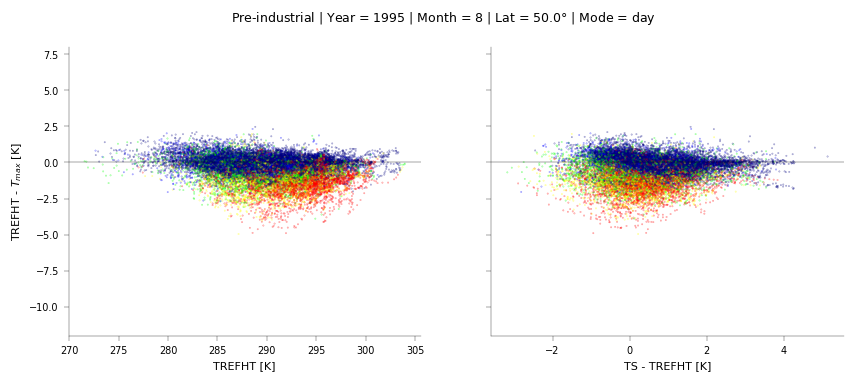

In [199]:
cmap = matplotlib.colors.ListedColormap(['navy', 'blue', 'lime', 'yellow', 'red'])
# Set color boundaries between integers
bounds = np.arange(-0.5, 5.5, 1)  # Centers each color on integer values
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
fig, ax = plt.subplots(1, 2, sharey=True)
isca_tools.plot.fig_resize(fig, 5*2)
ax[0].scatter(ds_use.TREFHT.where(ds_use.landmask>0).where(ds_use.lev_max>=0),
            (ds_use.TREFHT - ds_use.T_max).where(ds_use.landmask>0).where(ds_use.lev_max>=0),
            s=0.1, alpha=0.5, c=ds_use.lev_max, cmap=cmap, norm=norm)
ax[0].set_ylim(-12, 8)
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[0].set_xlabel('TREFHT [K]')
ax[0].set_ylabel('TREFHT - $T_{max}$ [K]')

ax[1].scatter((ds_use.TS - ds_use.TREFHT).where(ds_use.landmask>0).where(ds_use.lev_max>=0),
            (ds_use.TREFHT - ds_use.T_max).where(ds_use.landmask>0).where(ds_use.lev_max>=0),
            s=0.1, alpha=0.5, c=ds_use.lev_max, cmap=cmap, norm=norm)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[1].set_xlabel('TS - TREFHT [K]')
fig.suptitle(f'Pre-industrial | Year = {year_load} | Month = {month_load} | Lat = {ds_use.lat:.1f}$\degree$ | Mode = {av_type}', fontsize=9)
plt.show()

### Combine latitudes
Here we consider all days at all latitudes above a given quantile of temperature and with $T_{max}$ occuring at a particular level.

In [200]:
def get_color_groups(n_groups=8, n_repeat=None, cmap='jet', repeat=True):
    base_cmap = plt.get_cmap(cmap)      # Choose a base continuous colormap
    if n_repeat is None:
        n_repeat = int(np.ceil((ds.lat.size)/2/n_groups))
    # Extract 8 evenly spaced colors from the base colormap
    colors = [base_cmap(i / (n_groups - 1)) for i in range(n_groups)]
    # Repeat each color 12 times to get 96 colors
    repeated_colors = [color for color in colors for _ in range(n_repeat)]
    if repeat:
        repeated_colors = repeated_colors + repeated_colors[::-1]       # account for other hemisphere
    return repeated_colors

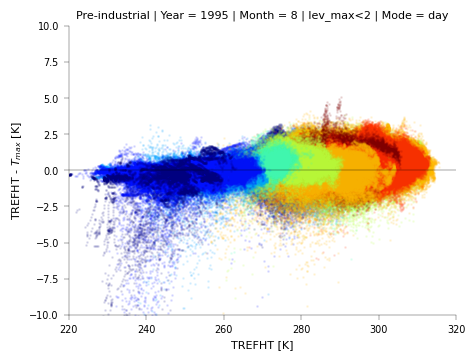

In [201]:
# Define discrete colormap
lev_max_plot = 2
quant_thresh = None
colors_lat = get_color_groups()         # color by latitude
fig, ax = plt.subplots(1, 1)
isca_tools.plot.fig_resize(fig, 5)
for i in range(ds.lat.size):
    ds_use = ds.isel(lat=i)
    ds_use = ds_use.where(ds_use.landmask>0)
    if quant_thresh is not None:
        ds_use = ds_use.where(ds_use.TREFHT>ds_use.TREFHT.quantile(quant_thresh, dim='time'))
    if lev_max_plot is not None:
        ds_use = ds_use.where(ds_use.lev_max<lev_max_plot)
    ax.scatter(ds_use.TREFHT, (ds_use.TREFHT - ds_use.T_max), s=1, alpha=0.1, color=colors_lat[i])
ax.axhline(0, color='k', lw=ax_linewidth)
ax.set_xlabel('TREFHT [K]')
ax.set_ylabel('TREFHT - $T_{max}$ [K]')
ax.set_title(f'Pre-industrial | Year = {year_load} | Month = {month_load} | lev_max<{lev_max_plot} | Mode = {av_type}')
ax.set_ylim(-10, 10)
ax.set_xlim(220, 320)
plt.show()

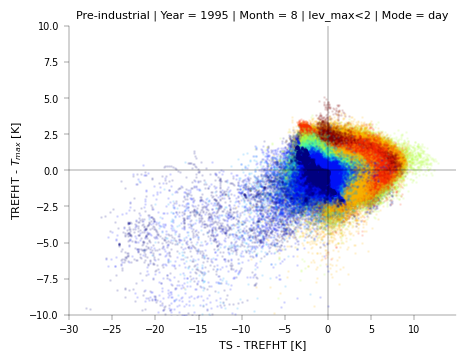

In [202]:
lev_max_plot = 2
quant_thresh = None
colors_lat = get_color_groups()         # color by latitude
fig, ax = plt.subplots(1, 1)
isca_tools.plot.fig_resize(fig, 5)
for i in range(ds.lat.size):
    ds_use = ds.isel(lat=i)
    ds_use = ds_use.where(ds_use.landmask>0)
    if quant_thresh is not None:
        ds_use = ds_use.where(ds_use.TREFHT>ds_use.TREFHT.quantile(quant_thresh, dim='time'))
    if lev_max_plot is not None:
        ds_use = ds_use.where(ds_use.lev_max<lev_max_plot)
    ax.scatter(ds_use.TS-ds_use.TREFHT, (ds_use.TREFHT - ds_use.T_max), s=1, alpha=0.1, color=colors_lat[i])
ax.axhline(0, color='k', lw=ax_linewidth)
ax.axvline(0, color='k', lw=ax_linewidth)
ax.set_xlabel('TS - TREFHT [K]')
ax.set_ylabel('TREFHT - $T_{max}$ [K]')
ax.set_title(f'Pre-industrial | Year = {year_load} | Month = {month_load} | lev_max<{lev_max_plot} | Mode = {av_type}')
ax.set_ylim(-10, 10)
# ax.set_xlim(220, 320)
plt.show()

### Fraction of days with a temperature inversion
Below I plot the fraction of days which have the TREFHT-$T_{max}$ temperature inversion to highlight that it occurs for most days.

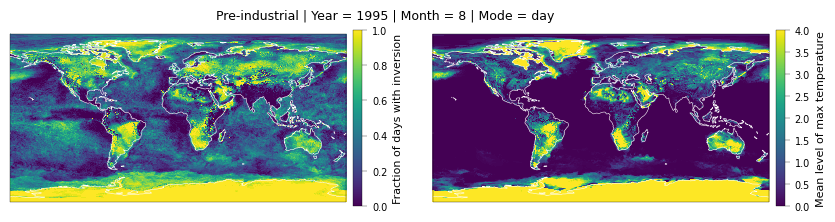

In [203]:
quant_thresh = None
if quant_thresh is not None:
    ds_use = ds.where(ds.TREFHT>ds.TREFHT.quantile(quant_thresh, dim='time'))
else:
    ds_use = ds
inversion_frac = (ds_use.T_max > ds_use.TREFHT).sum(dim='time')/(ds_use.TREFHT>0).sum(dim='time')
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})
isca_tools.plot.fig_resize(fig, 5*2)
im = inversion_frac.plot(vmin=0, vmax=1, ax=ax[0], add_colorbar=False)
plt.colorbar(im, ax=ax[0], fraction=0.025, pad=0.02, label='Fraction of days with inversion')
im = ds_use.lev_max.mean(dim='time').plot(vmin=0, vmax=4, ax=ax[1], add_colorbar=False)
plt.colorbar(im, ax=ax[1], fraction=0.025, pad=0.02, label='Mean level of max temperature')
for i in range(len(ax)):
    ax[i].coastlines(lw=0.4, color='w')
fig.suptitle(f'Pre-industrial | Year = {year_load} | Month = {month_load} | Mode = {av_type}', y=0.64, fontsize=9)
plt.show()